In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import os
# Change directory as per your location
os.chdir('/home/sourabh/Documents/TU-Berlin/ML-Project/pytorch-CycleGAN-and-pix2pix/')

In [2]:
# Preparing datasets
class Dataset(Dataset):

    def __init__(self, root='./datasets', data='maps', folder='train', transform=None):
        """ Init method

            Args:
                root (string):      Root directory of dataset
                data (string):      Data folder, Ie, Maps, Facade etc
                folder (sring):     Folder, Ie, Train, Test, Val
        """

        self.dataFolder = os.path.join(root, data, folder)
        self.transform = transform

        images = os.listdir(self.dataFolder)
        self.length = int(len(images))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):

        image = Image.fromarray(imageio.imread(
            os.path.join(self.dataFolder, '{}.jpg'.format(idx))))

        width, height = image.size
        width_half = int(width / 2)

        imageA = image.crop((0, 0, width_half, height))
        imageB = image.crop((width_half, 0, width, height))

        sample = {'imageA': imageA, 'imageB': imageB}

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [3]:
# Transformations
class Transform():
    """Perform transformations on Data"""

    def __init__(self, rescale=(256, 256), randomCrop=(255, 255), flip=False, toTensor=False):
        """ Init method

            Args:
                rescale (tuple):      Size of rescale, need to be done on Image
                randomCrop (tuple):   Cropping the image randomly with given size
                toTensor (boolean):   Covert array of Image to Torch.tensor
        """

        assert rescale is None or isinstance(rescale, tuple)
        assert randomCrop is None or isinstance(randomCrop, tuple)

        if rescale is not None and randomCrop is not None:
            assert rescale[0] >= randomCrop[0] \
                and rescale[0] >= randomCrop[1] \
                and rescale[1] >= randomCrop[0] \
                and rescale[1] >= randomCrop[0]

        # Order matters
        self.rescale = rescale
        self.randomCrop = randomCrop
        self.flip = flip
        self.toTensor = toTensor

    def __call__(self, sample):
        """ Call function

            Args:
            rescale (tuple):      Size of rescale, need to be done on Image
        """

        transformList = []

        if isinstance(self.rescale, tuple):
            transformList.append(Rescale(self.rescale))

        if isinstance(self.randomCrop, tuple):
            transformList.append(RandomCrop(self.randomCrop))

        if self.flip:
            transformList.append(Flip())

        # Tensor by default normalize the image
        if self.toTensor:
            transformList.append(ToTensor())

        return transforms.Compose(transformList)(sample)


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        imageA, imageB = sample['imageA'], sample['imageB']

        # imageA and imageB supposed to be of same shape
        h, w = imageA.size
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        imageA = imageA.resize((new_w, new_h))
        imageB = imageB.resize((new_w, new_h))

        return {'imageA': imageA, 'imageB': imageB}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        imageA, imageB = sample['imageA'], sample['imageB']

        # imageA and imageB supposed to be of same shape
        h, w = imageA.size
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        imageA = imageA.crop(box=(top, left, top + new_h, left + new_w))
        imageB = imageB.crop(box=(top, left, top + new_h, left + new_w))

        return {'imageA': imageA, 'imageB': imageB}


class Flip(object):

    def __call__(self, sample):
        """Flip the image randomly"""

        imageA, imageB = sample['imageA'], sample['imageB']

        imageA = imageA.transpose(Image.FLIP_LEFT_RIGHT)
        imageB = imageB.transpose(Image.FLIP_LEFT_RIGHT)

        return {'imageA': imageA, 'imageB': imageB}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        imageA, imageB = sample['imageA'], sample['imageB']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        imageA = transforms.ToTensor()(imageA)
        imageB = transforms.ToTensor()(imageB)

        return {'imageA': imageA, 'imageB': imageB}

In [4]:
class Visualizer():

    def __init__(self, sample):
        self.sample = sample

    def plot(self, numImage=5):
        """Plot images

            Args:
                sample:    Data, from Dataset class
                numImage:  total number of images you want to plot
        """

        print('----------Plotting images---------')

        numToDisplay = min(numImage, len(self.sample))
        for i in range(1, numToDisplay + 1):

            data = self.sample[i]

            imageA = data['imageA']
            imageB = data['imageB']

            plt.figure(figsize=(7, 15))

            ax1 = plt.subplot(numToDisplay, 2, 1)
            ax1.set_title('Satellite image')
            plt.imshow(imageA)

            ax2 = plt.subplot(numToDisplay, 2, 2)
            ax2.set_title('Map')
            plt.imshow(imageB)

            plt.show()

    def plotTensor(self, numImage=5):
        """Plot pytorch tensor images

            Args:
                sample:    Data, from Dataset class, in Tensor format
                numImage:  total number of images you want to plot
        """

        print('----------Plotting Tensor images---------')

        numToDisplay = min(numImage, len(self.sample))
        for i in range(1, numToDisplay + 1):

            data = self.sample[i]

            imageA = data['imageA']
            imageB = data['imageB']

            # un-transform the image data
            imageA = imageA.data   # get the image from it's Variable wrapper
            imageA = imageA.numpy()   # convert to numpy array from a Tensor
            # transpose to go from torch to numpy image
            imageA = np.transpose(imageA, (1, 2, 0))

            # un-transform the image data
            imageB = imageB.data   # get the image from it's Variable wrapper
            imageB = imageB.numpy()   # convert to numpy array from a Tensor
            # transpose to go from torch to numpy image
            imageB = np.transpose(imageB, (1, 2, 0))

            plt.figure(figsize=(7, 15))

            ax1 = plt.subplot(numToDisplay, 2, 1)
            ax1.set_title('Satellite image')
            plt.imshow(imageA)

            ax2 = plt.subplot(numToDisplay, 2, 2)
            ax2.set_title('Map')
            plt.imshow(imageB)

            plt.show()

----------Plotting images---------


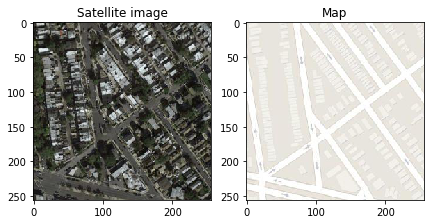

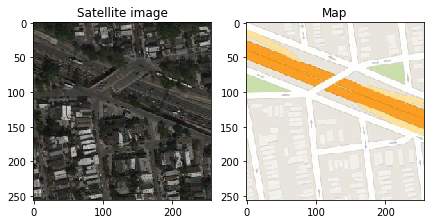

----------Plotting images---------


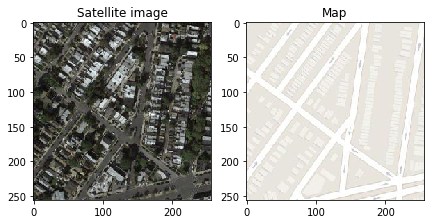

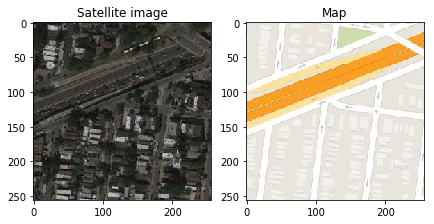

----------Plotting tensor images---------


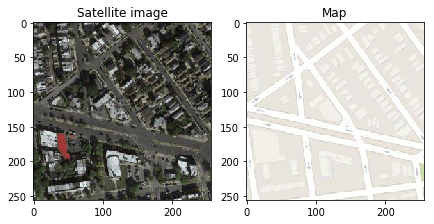

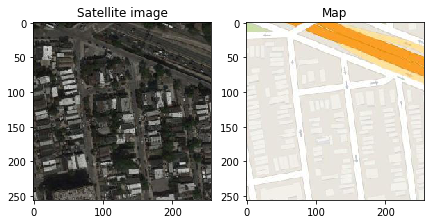

In [5]:
# Visualizingan Image
dataset = Dataset(data='maps', folder='train',
                  transform=Transform(rescale=(512, 512), randomCrop=(256, 256)))
Visualizer(dataset).plot(numImage=2)

# Visualizingan Flipped Image
dataset = Dataset(data='maps', folder='train',
                  transform=Transform(rescale=(512, 512), randomCrop=(256, 256), flip=True))
Visualizer(dataset).plot(numImage=2)

# Visualizing after coneverting Image to tensor
tensorDataset = Dataset(data='maps', folder='train',
                        transform=Transform(rescale=(512, 512), randomCrop=(256, 256), toTensor=True))
Visualizer(tensorDataset).plotTensor(numImage=2)